In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential, Input, Model
from keras.layers import Dense,Conv1D,Bidirectional,MaxPooling1D,Multiply,Flatten,Activation,LSTM,Dropout
from keras.optimizers import Adam
import yfinance as yf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


# Load Data

[*********************100%***********************]  1 of 1 completed


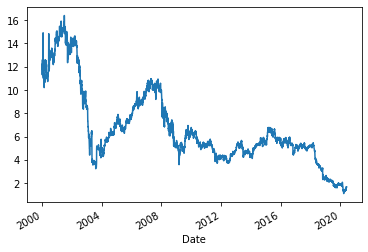

In [2]:
data=yf.download('AMP.AX','2000-01-01','2020-06-01')
data['Close'].plot()
plt.show()

# Prepare Data

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

past_days = 60
test_split_at = len(data) - 100 - past_days # test on the last 100 days

training_processed = data.iloc[:test_split_at,[1]]
training_scaled = scaler.fit_transform(training_processed.values)

features_set = []
labels = []
for i in range(past_days, test_split_at):
    features_set.append(training_scaled[i-past_days:i, 0])
    labels.append(training_scaled[i, 0])
    
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

# Split Data

In [4]:
from sklearn.model_selection import train_test_split 
features_set,feature_val,labels,label_val=train_test_split(features_set,labels,test_size=0.2,random_state=42)
feature_val.shape

(997, 60, 1)

# Create Baseline Model

We will create a baseline model to provide ourselves with a general overview of the data itself and how it is fitting to the model. From this we will then refine the parameters and network siz to produce a best fit model that lies welll between the over and underfitting of itself. 

In [6]:
def baseline_model(epochs='epochs',batch_size='batch_size'):

    base_model = Sequential()
    base_model.add(LSTM(units=50, return_sequences=True,input_shape=(features_set.shape[1], 1)))
    base_model.add(LSTM(units=50))
    base_model.add(Dense(units = 1))
    
    #compile model
    base_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    history=base_model.fit(features_set,labels,epochs = epochs, batch_size = batch_size, 
                           validation_data=(feature_val,label_val))
    
    #loss analysis 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

    #MAE Calculation 
    score=base_model.evaluate(feature_val,label_val,verbose=0)
    print('Val MAE: {}'.format(score))
    
    #Model Summary
    base_model.summary()
  
    return baseline_model

Epoch 1/100
125/125 [==============================] - 2s 13ms/step - loss: 0.0343 - val_loss: 0.0122
Epoch 2/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0143 - val_loss: 0.0119
Epoch 3/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0124 - val_loss: 0.0117
Epoch 4/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0117 - val_loss: 0.0135
Epoch 5/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 6/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0104 - val_loss: 0.0098
Epoch 7/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0100 - val_loss: 0.0088
Epoch 8/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 9/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 10/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0096 - val_l

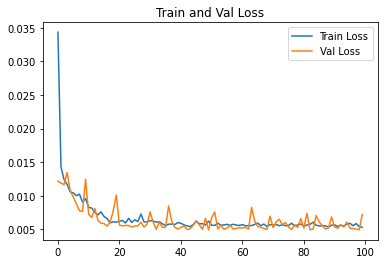

Val MAE: 0.007244927808642387
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [7]:
baseline1=baseline_model(epochs=100,batch_size=32)

We can see from the plots above that our baseline model is underfitting as the train loss is greater than the validation loss. However we can also see that we have resulted in low MAE which is an indication that the model structure we are using is suitable to this particular dataset. We can also note that the Loss for both the train and validation is constantly decreasing and approaching a convergence meaning that we whould decrease our number of epochs to see the affect. We will now create a model that clearly overfits by large amounts to have a range of parameters to work within. 

# Clear Overfit Model

We will now try and create a model that is clearly overfitting and determine the affects of this on different parameters whilst using the data. 

## Overfit Model One

In [8]:
def overfit_model(epochs='epochs',batch_size='batch_size'):

    base_model = Sequential()
    base_model.add(LSTM(units=10, return_sequences=True,input_shape=(features_set.shape[1], 1)))
    base_model.add(LSTM(units=10))
    base_model.add(Dense(units = 1))
  

    #compile model
    base_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    history=base_model.fit(features_set,labels,epochs = epochs, batch_size = batch_size, 
                           validation_data=(feature_val,label_val))
    
    #loss analysis 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

    #MAE Calculation 
    score=base_model.evaluate(feature_val,label_val,verbose=0)
    print('Val MAE: {}'.format(score))

    #Model Summary
    base_model.summary()

    return overfit_model

Epoch 1/200
63/63 [==============================] - 1s 20ms/step - loss: 0.1250 - val_loss: 0.0242
Epoch 2/200
63/63 [==============================] - 1s 8ms/step - loss: 0.0182 - val_loss: 0.0164
Epoch 3/200
63/63 [==============================] - 1s 8ms/step - loss: 0.0171 - val_loss: 0.0152
Epoch 4/200
63/63 [==============================] - 1s 8ms/step - loss: 0.0151 - val_loss: 0.0139
Epoch 5/200
63/63 [==============================] - 1s 8ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 6/200
63/63 [==============================] - 1s 8ms/step - loss: 0.0145 - val_loss: 0.0127
Epoch 7/200
63/63 [==============================] - 1s 8ms/step - loss: 0.0130 - val_loss: 0.0122
Epoch 8/200
63/63 [==============================] - 1s 8ms/step - loss: 0.0126 - val_loss: 0.0159
Epoch 9/200
63/63 [==============================] - 1s 8ms/step - loss: 0.0126 - val_loss: 0.0118
Epoch 10/200
63/63 [==============================] - 1s 8ms/step - loss: 0.0120 - val_loss: 0.0115
Epoch 11

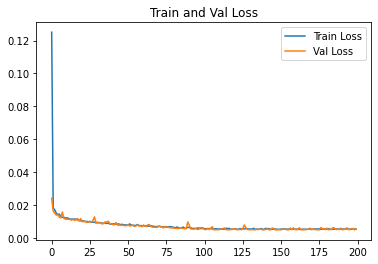

Val MAE: 0.0056147705763578415
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 10)            480       
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [9]:
overfit1=overfit_model(epochs=200,batch_size=64)

Having changed the number of LSTM units we can see a reduction in the MAE but we can also see the model is approaching a convergence gradually meaning we have a good fit of the model on the data however the number of paramters are quie low for a complex time series model that we should be using, we will now investigate further by changing the optimizer and adding in a learning rate to allow the model to learn the data slower and perhaps more specifically resulting in it performing starkly better on the Validation data than the training data. We can also note we have reduced the MAE from our baseline mark and also have made the training and validation loss curves more linear. 

## Overfit Model Two

In [10]:
#Define Optimizer Learning Rate
opt=Adam(lr=0.01)

In [11]:
def overfit_model2(epochs='epochs',batch_size='batch_size'):

    base_model = Sequential()
    base_model.add(LSTM(units=10, return_sequences=True,input_shape=(features_set.shape[1], 1)))
    base_model.add(LSTM(units=10))
    base_model.add(Dense(units = 1))
  

    #compile model
    base_model.compile(optimizer = opt, loss = 'mean_absolute_error')
    history=base_model.fit(features_set,labels,epochs = epochs, batch_size = batch_size, 
                           validation_data=(feature_val,label_val))
    
    #loss analysis 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

    #MAE Calculation 
    score=base_model.evaluate(feature_val,label_val,verbose=0)
    print('Val MAE: {}'.format(score))

    #Model Summary
    base_model.summary()
  
    return overfit_model2

Epoch 1/200
125/125 [==============================] - 2s 12ms/step - loss: 0.0248 - val_loss: 0.0108
Epoch 2/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0117 - val_loss: 0.0081
Epoch 3/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0111 - val_loss: 0.0152
Epoch 4/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0101 - val_loss: 0.0089
Epoch 5/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 6/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0087 - val_loss: 0.0109
Epoch 7/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 8/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0081 - val_loss: 0.0096
Epoch 9/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 10/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0073 - val_l

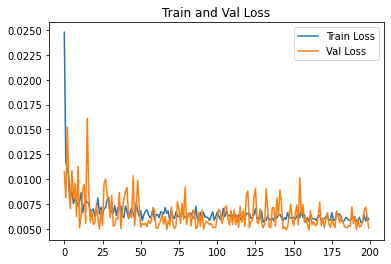

Val MAE: 0.0050947051495313644
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 10)            480       
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [12]:
overfit2=overfit_model2(epochs=200,batch_size=32)

We have been able to reduce the MAE further indicating the model is performing better on the data, however we have made a very noisy training and validation loss indicating that the addition of the learning rate has created large fluctuations within the model predictions.We will now adopt a more complex network to see if this has any affect combined with the reduced LSTM Units, Dropout Rate, Activation Layer and Learning Rate.

## Overfit Model Three

In [13]:
def overfit_model3(epochs='epochs',batch_size='batch_size'):

    base_model = Sequential()
    base_model.add(LSTM(units=10, return_sequences=True,input_shape=(features_set.shape[1], 1)))
    base_model.add(Dropout(0.2))
    base_model.add(LSTM(units=10,return_sequences=False))
    base_model.add(Dropout(0.2))
    base_model.add(Activation('relu'))
    base_model.add(Dense(units = 1))
  

    #compile model
    base_model.compile(optimizer = 'rmsprop', loss = 'mean_absolute_error')
    history=base_model.fit(features_set,labels,epochs = epochs, batch_size = batch_size, 
                           validation_data=(feature_val,label_val))
    
    #loss analysis 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

    #MAE Calculation 
    score=base_model.evaluate(feature_val,label_val,verbose=0)
    print('Val MAE: {}'.format(score))

    #Model Summary
    base_model.summary()
  
    return overfit_model3

Epoch 1/200
125/125 [==============================] - 2s 13ms/step - loss: 0.1007 - val_loss: 0.0228
Epoch 2/200
125/125 [==============================] - 1s 9ms/step - loss: 0.0586 - val_loss: 0.0324
Epoch 3/200
125/125 [==============================] - 1s 9ms/step - loss: 0.0504 - val_loss: 0.0290
Epoch 4/200
125/125 [==============================] - 1s 9ms/step - loss: 0.0466 - val_loss: 0.0442
Epoch 5/200
125/125 [==============================] - 1s 9ms/step - loss: 0.0393 - val_loss: 0.0207
Epoch 6/200
125/125 [==============================] - 1s 9ms/step - loss: 0.0395 - val_loss: 0.0235
Epoch 7/200
125/125 [==============================] - 1s 9ms/step - loss: 0.0352 - val_loss: 0.0153
Epoch 8/200
125/125 [==============================] - 1s 9ms/step - loss: 0.0354 - val_loss: 0.0223
Epoch 9/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0348 - val_loss: 0.0294
Epoch 10/200
125/125 [==============================] - 1s 9ms/step - loss: 0.0352 - val_l

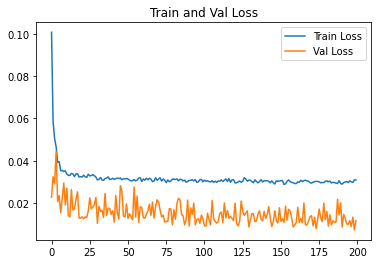

Val MAE: 0.011578385718166828
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 10)            480       
_________________________________________________________________
dropout (Dropout)            (None, 60, 10)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
______________________

In [14]:
overfit3=overfit_model3(epochs=200,batch_size=32)

Despite trying to make the model more complex, the model is underfitting more now indicating that the increased complexity is only making the model learn the training data more than the validation data without determining the trends and changes indicating the model is not generalizing. As we have been unable to make a model that overfits we will now build 3 models being a CNN,CNN-LSTM,  and CNN+LSTM+Attention to see the various performances of the variety of models. 

# CNN Model

We will be using a CNN model to reduce the overfitting of the model as CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "fully-connectedness" of these networks makes them prone to overfitting data. 

In [15]:
  def cnn_model(epochs='epochs',batch_size='batch_size'):
    
    #Model Structure 
    cnn_model = Sequential()
    cnn_model.add(Dense(128,input_shape=(features_set.shape[1], 1)))
    cnn_model.add(Conv1D(filters = 112, kernel_size= 1,padding='valid', activation='relu', kernel_initializer="uniform"))
    cnn_model.add(MaxPooling1D(pool_size=2, padding='valid'))
    cnn_model.add(Conv1D(filters = 64,kernel_size = 1,padding='valid', activation='relu', kernel_initializer="uniform"))
    cnn_model.add(MaxPooling1D(pool_size=1, padding='valid'))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(100, activation="relu", kernel_initializer="uniform"))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    
    #Model Compile
    cnn_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    history=cnn_model.fit(features_set,labels,epochs = epochs, batch_size = batch_size, 
                           validation_data=(feature_val,label_val))
    
    #Loss Analysis 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

    #MAE Calculation 
    score=cnn_model.evaluate(feature_val,label_val,verbose=0)
    print('Val MAE: {}'.format(score))
    
    #Model Summary
    cnn_model.summary()

    return cnn_model

Epoch 1/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0623 - val_loss: 0.0282
Epoch 2/200
125/125 [==============================] - 0s 3ms/step - loss: 0.0308 - val_loss: 0.0163
Epoch 3/200
125/125 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.0146
Epoch 4/200
125/125 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.0124
Epoch 5/200
125/125 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0125
Epoch 6/200
125/125 [==============================] - 0s 3ms/step - loss: 0.0246 - val_loss: 0.0124
Epoch 7/200
125/125 [==============================] - 0s 3ms/step - loss: 0.0254 - val_loss: 0.0195
Epoch 8/200
125/125 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.0177
Epoch 9/200
125/125 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0178
Epoch 10/200
125/125 [==============================] - 0s 3ms/step - loss: 0.0208 - val_lo

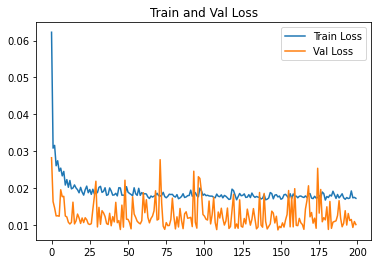

Val MAE: 0.010088089853525162
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 60, 128)           256       
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 112)           14448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 112)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 64)            7232      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
flatten (Flatten)       

In [16]:
cnn1=cnn_model(epochs=200,batch_size=32)

The use of a CNN model has drastically increased the number of paramaters we are, due to its ability to be prone to overfitting, we can see that the model is underfitting and the model is learning the training data instead of geenralizing and applying its knowledge to the valdiation data. We have also seen an increase in the MAE and have developed a model with 214k paramters which is not ideal as our previous models did not exceed 5k paramters with a low MAE. 

# CNN + LSTM Model

In [17]:
  def cnn_lstm_model(epochs='epochs',batch_size='batch_size'):

    #Model Structure 
    cl_model = Sequential()
    cl_model.add(Conv1D(16, kernel_size= (3),input_shape=(features_set.shape[1], 1)))
    cl_model.add(MaxPooling1D(pool_size=(2)))
    cl_model.add(LSTM(units=32,return_sequences=True))
    cl_model.add(Flatten())
    cl_model.add(Dense(1, activation="tanh"))


    #Model Compile
    cl_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    history=cl_model.fit(features_set,labels,epochs = epochs, batch_size = batch_size, 
                           validation_data=(feature_val,label_val))
    
    #Loss Analysis 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

    #MAE Calculation 
    score=cl_model.evaluate(feature_val,label_val,verbose=0)
    print('Val MAE: {}'.format(score))

    #Model Summary
    cl_model.summary()

    return cnn_lstm_model

Epoch 1/200
125/125 [==============================] - 1s 8ms/step - loss: 0.0478 - val_loss: 0.0229
Epoch 2/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0216 - val_loss: 0.0180
Epoch 3/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0189 - val_loss: 0.0204
Epoch 4/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0174
Epoch 5/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0171 - val_loss: 0.0145
Epoch 6/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0151
Epoch 7/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0136
Epoch 8/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0151 - val_loss: 0.0137
Epoch 9/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 10/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - val_lo

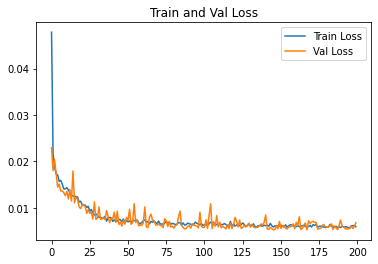

Val MAE: 0.0067865727469325066
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 58, 16)            64        
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 29, 16)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 29, 32)            6272      
_________________________________________________________________
flatten_3 (Flatten)          (None, 928)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 929       
Total params: 7,265
Trainable params: 7,265
Non-trainable params: 0
_________________________________________________________________


In [18]:
cnn_lstm1=cnn_lstm_model(epochs=200,batch_size=32)

The use of the CNN model attached to the LSTM model has provided a significant improvement from the basic CNN structure. We have been able to reduce our total number of parameters by 4 times and have alos seen a further reduction in the Validation MAE, this is indicating that this model might be a better model thus far. Another observation we can see is that the Train and Val Loss curves are meeting each other indicating the mdoel is not under or overfitting and hence we have removed the problem we had in the previous model. The model can be seen to overfit from around epoch 25 onwards however we will look into this furher down. 

# CNN+Attention+LSTN Fusion Model

## Model Construction 

In [19]:
inputs=Input(shape=(features_set.shape[1], 1))
model=Conv1D(filters = 16, kernel_size = 1, activation = 'sigmoid')(inputs)
model=MaxPooling1D(pool_size = 60)(model)
model=Dropout(0.01)(model)
model=Bidirectional(LSTM(16, activation='tanh'), name='bilstm')(model)
attention=Dense(16*2, activation='sigmoid', name='attention_vec')(model)
model=Multiply()([model, attention])
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mean_absolute_error',optimizer='adam')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 60, 16)       32          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 1, 16)        0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 1, 16)        0           max_pooling1d_6[0][0]            
_______________________________________________________________________________________

## Model Run

In [20]:
history_cal=model.fit(features_set,labels, epochs=200, 
                  batch_size = 32,validation_data=(feature_val,label_val))

Epoch 1/200
125/125 [==============================] - 1s 10ms/step - loss: 0.1824 - val_loss: 0.1558
Epoch 2/200
125/125 [==============================] - 1s 5ms/step - loss: 0.1494 - val_loss: 0.1513
Epoch 3/200
125/125 [==============================] - 1s 5ms/step - loss: 0.1431 - val_loss: 0.1396
Epoch 4/200
125/125 [==============================] - 1s 5ms/step - loss: 0.1191 - val_loss: 0.0869
Epoch 5/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0602 - val_loss: 0.0319
Epoch 6/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0483 - val_loss: 0.0421
Epoch 7/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0495 - val_loss: 0.0301
Epoch 8/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0456 - val_loss: 0.0298
Epoch 9/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0453 - val_loss: 0.0332
Epoch 10/200
125/125 [==============================] - 1s 5ms/step - loss: 0.0430 - val_l

## Model Analysis

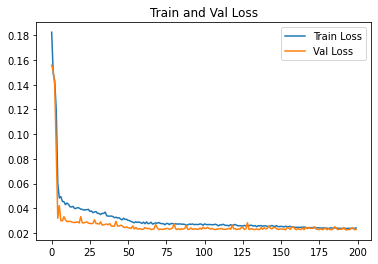

In [21]:
loss = history_cal.history['loss']
val_loss = history_cal.history['val_loss']
epochs_range = range(200)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

In [22]:
score=model.evaluate(feature_val,label_val,verbose=0)
print('Val MAE: {}'.format(score))

Val MAE: 0.02277173474431038


We have implemented an Attention layer, this provides the ability to look over all the information the original data set holds, then generate a prediction according to current data. However we have attached this to a CNN and LSTM model which has seen to increase the Validation MAE significantly and also has seen to converge after a longer time indicating that the model is underfitting even up to epoch number 200. This model doesn't seem ideal in accordance to the previous one which was able to beat the baseline model and provide a low MAE whilst retaining a low number of parameters. We can see this model has 5k paramters but in addition to its Validation MAE and Loss it seems as a non optimal model. 

# Refining Best Model

We can see that from the models aobe our best two are the CNN and CNN+LSTM models with the smallest model at only 5K paramters being the Fusion model. However we should note that the CNN Model has over 200K parameters whereas the CNN+LSTM Model has only 7295 paramteres and a MAE of 0.0067. The CNN+LSTM Model demonstrates the lowest MAE at 0.0067. As our goal is to find the model that doesn't under or overfit whilst having a low MAE with a small amount of parameters we will continue to tune the CNN+LSTM Model. 

## CNN Refined Model One

We will be using the same network size as the original CNN+LSTM model and fine tune the hyperparameters manually. 

In [23]:
def cnn_lstm_model2(epochs='epochs',batch_size='batch_size'):

    #Model Structure 
    cl_model = Sequential()
    cl_model.add(Conv1D(16, kernel_size= (6),input_shape=(features_set.shape[1], 1)))
    cl_model.add(MaxPooling1D(pool_size=(4)))
    cl_model.add(LSTM(units=32,return_sequences=True))
    cl_model.add(Flatten())
    cl_model.add(Dense(1, activation="tanh"))

    #Model Compile
    cl_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    history=cl_model.fit(features_set,labels,epochs = epochs, batch_size = batch_size, 
                           validation_data=(feature_val,label_val))
    
    #Loss Analysis 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

    #MAE Calculation 
    score=cl_model.evaluate(feature_val,label_val,verbose=0)
    print('Val MAE: {}'.format(score))

    #Model Summary
    cl_model.summary()

    return cnn_lstm_model2

Epoch 1/50
125/125 [==============================] - 1s 7ms/step - loss: 0.0507 - val_loss: 0.0309
Epoch 2/50
125/125 [==============================] - 1s 4ms/step - loss: 0.0296 - val_loss: 0.0268
Epoch 3/50
125/125 [==============================] - 1s 4ms/step - loss: 0.0258 - val_loss: 0.0260
Epoch 4/50
125/125 [==============================] - 1s 4ms/step - loss: 0.0237 - val_loss: 0.0219
Epoch 5/50
125/125 [==============================] - 1s 4ms/step - loss: 0.0219 - val_loss: 0.0198
Epoch 6/50
125/125 [==============================] - 1s 4ms/step - loss: 0.0204 - val_loss: 0.0175
Epoch 7/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0199
Epoch 8/50
125/125 [==============================] - 1s 4ms/step - loss: 0.0192 - val_loss: 0.0179
Epoch 9/50
125/125 [==============================] - 1s 4ms/step - loss: 0.0182 - val_loss: 0.0166
Epoch 10/50
125/125 [==============================] - 1s 4ms/step - loss: 0.0182 - val_loss: 0.0162

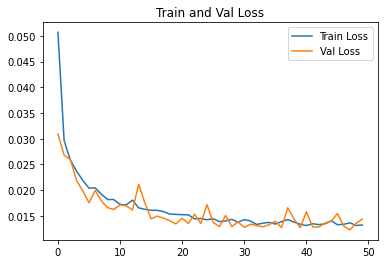

Val MAE: 0.014356452971696854
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 55, 16)            112       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 13, 16)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 13, 32)            6272      
_________________________________________________________________
flatten_4 (Flatten)          (None, 416)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 417       
Total params: 6,801
Trainable params: 6,801
Non-trainable params: 0
_________________________________________________________________


In [24]:
cnn_lstm2=cnn_lstm_model2(epochs=50,batch_size=32)

After doubling the kernel and pool size we can see that the Validation MAE has increased and a bit of noise has been introduced into the Validation and Train loss curves. A reduction is seen in the number of parameters due to this however we will not proceed to further investigate this model. 

## CNN Refined Model Two

In [25]:
def cnn_lstm_model3(epochs='epochs',batch_size='batch_size'):

    #Model Structure 
    cl_model = Sequential()
    cl_model.add(Conv1D(32, kernel_size= (3),input_shape=(features_set.shape[1], 1)))
    cl_model.add(MaxPooling1D(pool_size=(2)))
    cl_model.add(LSTM(units=64,return_sequences=True))
    cl_model.add(Flatten())
    cl_model.add(Dense(1, activation="tanh"))

    #Model Compile
    cl_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    history=cl_model.fit(features_set,labels,epochs = epochs, batch_size = batch_size, 
                           validation_data=(feature_val,label_val))
    
    #Loss Analysis 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

    #MAE Calculation 
    score=cl_model.evaluate(feature_val,label_val,verbose=0)
    print('Val MAE: {}'.format(score))

    #Model Summary
    cl_model.summary()

    return cnn_lstm_model3

Epoch 1/50
125/125 [==============================] - 1s 8ms/step - loss: 0.0338 - val_loss: 0.0256
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0214 - val_loss: 0.0186
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0179 - val_loss: 0.0139
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0154 - val_loss: 0.0135
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0136 - val_loss: 0.0110
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0134 - val_loss: 0.0105
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0116 - val_loss: 0.0097
Epoch 8/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0087
Epoch 9/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 10/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0079

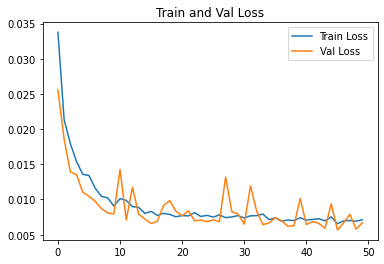

Val MAE: 0.006687988992780447
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 58, 32)            128       
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 29, 32)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 29, 64)            24832     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1856)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 1857      
Total params: 26,817
Trainable params: 26,817
Non-trainable params: 0
_________________________________________________________________


In [26]:
cnn_lstm3=cnn_lstm_model3(epochs=50,batch_size=32)

After doubling the CONV1D Units and LSTM Units we can see that the number of parameters has significantly increased and that the Validation MAE has decreased however alot of noise has been introduced into the Validation and Train Loss curves indicating that this was not optimal. We will now try with the dropout layer and see the affect. 

## CNN Refined Model Three

In [27]:
def cnn_lstm_model4(epochs='epochs',batch_size='batch_size'):

    #Model Structure 
    cl_model = Sequential()
    cl_model.add(Conv1D(16, kernel_size= (3),input_shape=(features_set.shape[1], 1)))
    cl_model.add(MaxPooling1D(pool_size=(2)))
    cl_model.add(LSTM(units=32,return_sequences=True))
    cl_model.add(Dropout(0.1))
    cl_model.add(Flatten())
    cl_model.add(Dense(1, activation="tanh"))

    #Model Compile
    cl_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    history=cl_model.fit(features_set,labels,epochs = epochs, batch_size = batch_size, 
                           validation_data=(feature_val,label_val))
    
    #Loss Analysis 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

    #MAE Calculation 
    score=cl_model.evaluate(feature_val,label_val,verbose=0)
    print('Val MAE: {}'.format(score))

    #Model Summary
    cl_model.summary()

    return cnn_lstm_model4

Epoch 1/25
125/125 [==============================] - 1s 8ms/step - loss: 0.0468 - val_loss: 0.0303
Epoch 2/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0268 - val_loss: 0.0197
Epoch 3/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0225 - val_loss: 0.0188
Epoch 4/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0214 - val_loss: 0.0161
Epoch 5/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0193 - val_loss: 0.0157
Epoch 6/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0191 - val_loss: 0.0140
Epoch 7/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0163
Epoch 8/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0129
Epoch 9/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0117
Epoch 10/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0129

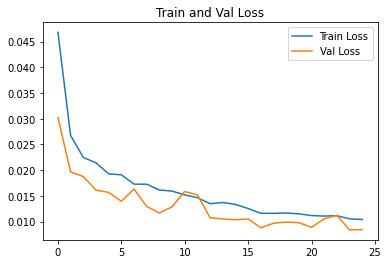

Val MAE: 0.008426864631474018
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 58, 16)            64        
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 29, 16)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 29, 32)            6272      
_________________________________________________________________
dropout_10 (Dropout)         (None, 29, 32)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 928)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 929       
Total params: 7,265
Trainable params: 7,265
Non-trainable params: 0
_____________________

In [28]:
cnn_lstm4=cnn_lstm_model4(epochs=25,batch_size=32)

The addition of the Dropout layer has helped to reduce the noise in the validation and loss curves and also provide us a low MAE whilst retaining a low number of parameters. We can see that this model is providing a good balance between over amd underfitting and is meeting the criteria outlined intially. We will use this model as our final model and test it to see the results. 

# Best Model

After the fine tuning, we will now produce the Prediction Graph and Test MSE on our best model. 

In [29]:
def best_model(epochs='epochs',batch_size='batch_size'):

    #Model Structure 
    best_model = Sequential()
    best_model.add(Conv1D(16, kernel_size= (3),input_shape=(features_set.shape[1], 1)))
    best_model.add(MaxPooling1D(pool_size=(2)))
    best_model.add(LSTM(units=32,return_sequences=True))
    best_model.add(Dropout(0.1))
    best_model.add(Flatten())
    best_model.add(Dense(1, activation="tanh"))

    #Model Compile
    best_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    history=best_model.fit(features_set,labels,epochs = epochs, batch_size = batch_size, 
                           validation_data=(feature_val,label_val))
    
    #Loss Analysis 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()
    
    #Prediction Analysis
    testing_complete = data.iloc[test_split_at:,]
    testing_processed = testing_complete.iloc[:, 1].values

    test_inputs = testing_processed
    test_inputs = test_inputs.reshape(-1,1)
    test_inputs = scaler.transform(test_inputs)
    test_features = []
    for i in range(past_days, len(test_inputs)):
        test_features.append(test_inputs[i-past_days:i, 0])
    
    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    predictions = best_model.predict(test_features)
    predictions = scaler.inverse_transform(predictions)

    plt.figure(figsize=(10,6))
    plt.plot(testing_processed[past_days:,], color='blue', label='Actual Stock Price')
    plt.plot(predictions , color='red', label='Predicted Stock Price')
    plt.title('Stock Price Prediction - last 100 days of data')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()    

    #MAE Calculation 
    score=best_model.evaluate(feature_val,label_val,verbose=0)
    print('Val MAE: {}'.format(score))

    #MSE Calculation 
    score2=mean_squared_error(testing_processed[past_days:,],predictions)
    print('Test MSE: {}'.format(score2))
    
    #Model Summary
    best_model.summary()

    return best_model

Epoch 1/25
125/125 [==============================] - 1s 7ms/step - loss: 0.0453 - val_loss: 0.0279
Epoch 2/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0256 - val_loss: 0.0244
Epoch 3/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0228 - val_loss: 0.0187
Epoch 4/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0209 - val_loss: 0.0170
Epoch 5/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0192 - val_loss: 0.0162
Epoch 6/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0190 - val_loss: 0.0193
Epoch 7/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 8/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0131
Epoch 9/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0170 - val_loss: 0.0142
Epoch 10/25
125/125 [==============================] - 1s 5ms/step - loss: 0.0160 - val_loss: 0.0132

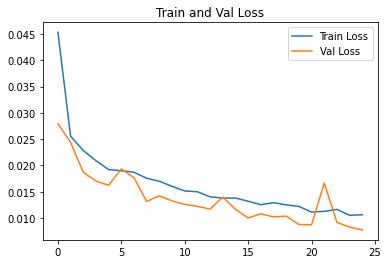

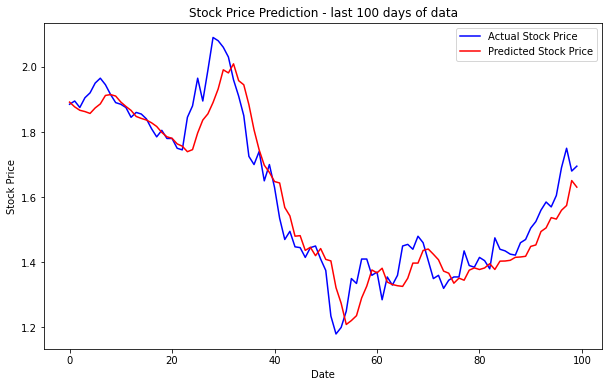

Val MAE: 0.007738947402685881
Test MSE: 0.005211040570324315
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 58, 16)            64        
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 29, 16)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 29, 32)            6272      
_________________________________________________________________
dropout_11 (Dropout)         (None, 29, 32)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 928)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 929       
Total params: 7,265
Trainable params: 7,265
Non-trainable 

In [30]:
bmodel=best_model(epochs=25,batch_size=32)

We can see that the original CNN+LSTM model was the best depsite the fine tuning that was conducted on the model. We were able to achieve a Validation MAE of 0.0077 and the data could be seen to predict well as seen by the graph above. We can see that the Predicted Stock Price was quite close to the True Stock Price indicating that the model could generalize well. The test MSE was also quite low and we can also see that the number of parameters on the model were also low at 7265 which provided us very little under or overfitting and by looking at the Train and Validation loss curves we could see the model was not over or underfitting and the optimal number of epochs was 25. The only change made was the addition of the Dropout Rate. 